### 1. Read in data

In [35]:
import pandas as pd
import numpy as np
import spacy 
from spacy.lang.en import English
import seaborn as sns
import time
import matplotlib.pyplot as plt

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_csv('/home/jupyter/sb-entity-classification/data/data.csv')
df.columns = ['class','name']

classes_list = pd.read_csv('/home/jupyter/sb-entity-classification/data/classes.txt', header = None)
classes_list['class'] = classes_list.index
classes_list.columns = ['class_name', 'class']
classes_list['class'] = classes_list['class'] + 1  # based on information provided in the brief

df = df.merge(classes_list, on = 'class', how = 'left')

### 2. Run SpaCy NER

In [85]:
#### not running this cell in exploratory phase because it took too long. Explore on a smaller sample instead.
# %%time
# df['entities'] = df['name'].apply(lambda x: [(i, i.label_) for i in nlp(x).ents])

KeyboardInterrupt: 

In [7]:
df = df.sample(5000)

%%time
df['NER'] = df['name'].apply(lambda x: [(i, i.label_) for i in nlp(x).ents])

### 3. Analyses on NER results

In [26]:
df.sample(5)

,class,name,class_name,NER,NER_len
50725,2,Kirbyville High School,EducationalInstitution,"[((Kirbyville, High, School), ORG)]",1
340952,9,Hředle (Beroun District),Village,[],0
442730,12,Live at the Hollywood Bowl (Ben Harper film),Album,"[((the, Hollywood, Bowl), FAC), ((Ben, Harper)...",2
466081,12,The Meadowlands (album),Album,[],0
515833,13,The Elder,Film,[],0


_Observations_:
1. educational institution, means of transport are (rightly) grouped into 'organization';
2. explicit genre keywords, such as 'film' and 'album' were not identified, as expected, but means that NER alone would not be enough;
3. names for album, film, written work are not typically identified if names of the artist is not included in them;
4. There are examples of multiple named entitied being identified. 

#### 3.1 Number of NER in each name?

<AxesSubplot:xlabel='NER_len', ylabel='Probability'>

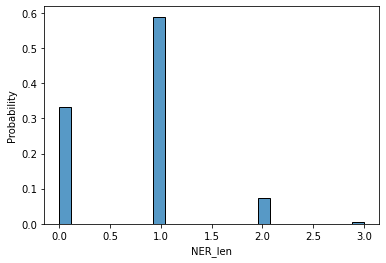

In [32]:
df['NER_len'] = df['NER'].apply(lambda x: len(x))

sns.histplot(df['NER_len'], kde = False, stat="probability")

<BarContainer object of 14 artists>

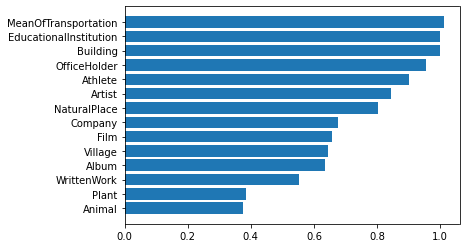

In [36]:
plt.barh(df.groupby('class_name').mean()['NER_len'].sort_values().index, 
         df.groupby('class_name').mean()['NER_len'].sort_values(), 
         align='center')

_Observations_:
1. 30% names do not contain recognized named identities;
2. Typically(~60%) names in this dataset contain 1 NER, ~10% contain two, and rare cases contain three. 
3. Mean of Transportation, Educational Institution, and Building have higher average NER count per name.   

#### 3.2 Correlation (co-occurrence) between NER and classes?

For convenience, analyze those with only one recognised NER

In [20]:
one_ner = df[df['NER_len']==1]

one_ner['NER_label'] = one_ner['NER'].apply(lambda x: x[0][1])
count_df = pd.DataFrame(pd.DataFrame(one_ner.groupby(['NER_label', 'class_name']).size()).to_records())
count_df.columns = ['NER_label','class_name', 'count']
count_df.pivot('NER_label','class_name', 'count')

<AxesSubplot:xlabel='class_name', ylabel='NER_label'>

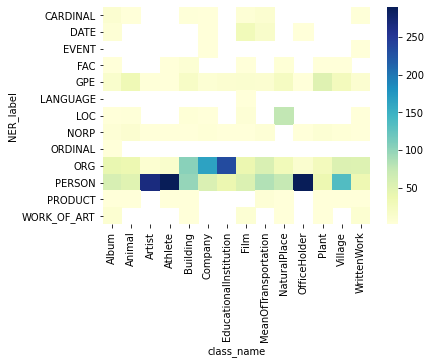

In [22]:
sns.heatmap(count_df.pivot('NER_label','class_name', 'count'),cmap="YlGnBu")

_Observations_:
1. PERSON and ORG are the more prevalent NER labels, and seem to appear for mostly sensible classes.
2. Some of these NER labels' names do not make immediate sense.

#### 3.3 Look at explanations of the NER labels

In [53]:
NERs = count_df['NER_label'].unique().tolist()

for x in NERs:
    print('{}, meaning {}'.format(x, spacy.explain(x)))

CARDINAL, meaning Numerals that do not fall under another type
DATE, meaning Absolute or relative dates or periods
EVENT, meaning Named hurricanes, battles, wars, sports events, etc.
FAC, meaning Buildings, airports, highways, bridges, etc.
GPE, meaning Countries, cities, states
LANGUAGE, meaning Any named language
LOC, meaning Non-GPE locations, mountain ranges, bodies of water
NORP, meaning Nationalities or religious or political groups
ORDINAL, meaning "first", "second", etc.
ORG, meaning Companies, agencies, institutions, etc.
PERSON, meaning People, including fictional
PRODUCT, meaning Objects, vehicles, foods, etc. (not services)
WORK_OF_ART, meaning Titles of books, songs, etc.


_Observations and Thoughts on Modeling_:

Some of the NERs are roughly super class of some of the classes that need to be identified, suggesting that (1) these NER labels would be very useful information for classification, and can be used either as the first step, or in a more end-to-end fashion, should form informative features; (2) the semantic meaning of the explanation itself can be exploited too, as some of the examples contain the name of the class itself. 

#### 3.4 Extract all NER labels from each name, and discard the NER itself 

In [54]:
#### towards feature engineering

df_features = df.copy()
df_features['NER_labels'] = df_features['name'].apply(lambda x: [i.label_ for i in nlp(x).ents])

In [49]:
def break_camel_formatted_phrase(text):
    return ' '.join(re.findall('[A-Z][^A-Z]*', text))

def format_class_name(text):
    return break_camel_formatted_phrase(text).lower()

In [48]:
classes_list['class_name'] = classes_list['class_name'].apply(lambda x: format_class_name(x))

In [50]:
doc = nlp(','.join(classes_list['class_name'].tolist()))

In [52]:
doc

company,educational institution,artist,athlete,office holder,mean of transportation,building,natural place,village,animal,plant,album,film,written work